## Load the Adult Data

In [3]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
dir_path = '/content/drive/MyDrive/CSE_248/'


In [5]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchattacks-3.2.6-py3-none-any.whl (105 kB)


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import unsqueeze
import torchattacks


Load the CIFAR dataset as numpy array.

In [2]:
# Image preprocessing modules
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])

In [3]:
# Download data 
train_data = datasets.FashionMNIST(root = '.',
                              train = True,
                              download = True, 
                              transform=transform)
test_data = datasets.FashionMNIST(root = '.',
                             train = False, 
                             download = True, 
                             transform=transform)


In [4]:
features_train = np.zeros((12000, 32, 32))
label_train = np.zeros((12000,))
count = 0
for i in range(train_data.data.shape[0]):
    features, label = train_data.__getitem__(i)
    if label == 0 or label == 1:
        features_train[count] = features.detach().numpy()
        label_train[count] = label
        count += 1

features_train = np.asarray(features_train)
label_train = np.asarray(label_train)



In [5]:
features_test = np.zeros((2000, 32, 32))
label_test = np.zeros((2000,))
count = 0
for i in range(test_data.data.shape[0]):
    features, label = test_data.__getitem__(i)
    if label == 0 or label == 1:
        features_test[count] = features.detach().numpy()
        label_test[count] = label
        count += 1

features_test = np.asarray(features_test)
label_test = np.asarray(label_test)

(32, 32)
This is a T-shirt:


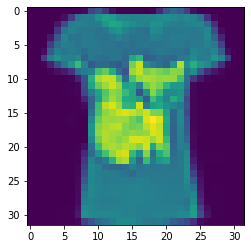

(32, 32)
This is a T-shirt:


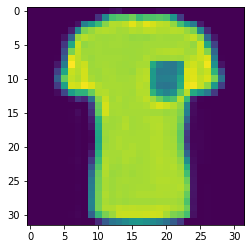

(32, 32)
This is a Trouser:


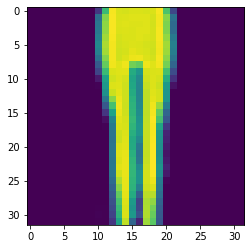

(32, 32)
This is a Trouser:


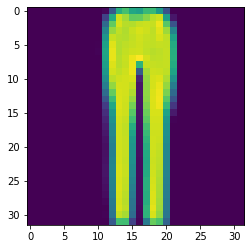

(32, 32)
This is a Trouser:


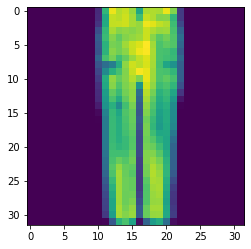

In [6]:
# Preview a sample of the images
def display_images(n, features_train, label_train, random = True):
    label_names = {0: 'T-shirt',
                   1:'Trouser'}
    if random:
        indices = np.random.choice(features_train.shape[0], size=n)
    else:
        indices = np.arange(n)
    for i in indices:
        image = features_train[i]
        print(image.shape)
        label = label_train[i]
        print('This is a {}:'.format(label_names[label]))
        plt.figure()
        plt.imshow(image)
        plt.show()
display_images(5, features_train, label_train)

Load the numpy array as torch tensors.

In [7]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 128 
# prepare the dataloader
train_dataset = TensorDataset(torch.flatten(torch.Tensor(features_train).float(), start_dim=1), torch.Tensor(label_train))
val_dataset = TensorDataset(torch.flatten(torch.Tensor(features_test).float(), start_dim=1), torch.Tensor(label_test))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)



In [8]:
import torch.nn as nn
from torch.nn.functional import normalize

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=1024, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = output.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor):
    return normalize(tensor, p=2.0, dim = 0)

## Natural training

In [9]:
LR = 0.01
NUM_EPOCH = 20
LOG_STEP = 200


our_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(our_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    our_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader):   
        
        train_labels = train_labels.long()
        output = our_net(train_sample)
        loss = criterion(output, train_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    our_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            # outputs = our_net(normalization(val_sample, mean=mean, std=std).float())
            outputs = our_net(val_sample)
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))
        
        

Epoch 0 Current Step 0/94: loss is 0.630730
------------------------------------------------
Epoch 0 Validation acc is 0.980273
Epoch 1 Current Step 0/94: loss is 0.022306
------------------------------------------------
Epoch 1 Validation acc is 0.980566
Epoch 2 Current Step 0/94: loss is 0.020232
------------------------------------------------
Epoch 2 Validation acc is 0.985937
Epoch 3 Current Step 0/94: loss is 0.009576
------------------------------------------------
Epoch 3 Validation acc is 0.985449
Epoch 4 Current Step 0/94: loss is 0.015502
------------------------------------------------
Epoch 4 Validation acc is 0.986426
Epoch 5 Current Step 0/94: loss is 0.002156
------------------------------------------------
Epoch 5 Validation acc is 0.984961
Epoch 6 Current Step 0/94: loss is 0.006566
------------------------------------------------
Epoch 6 Validation acc is 0.984668
Epoch 7 Current Step 0/94: loss is 0.037133


KeyboardInterrupt: 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


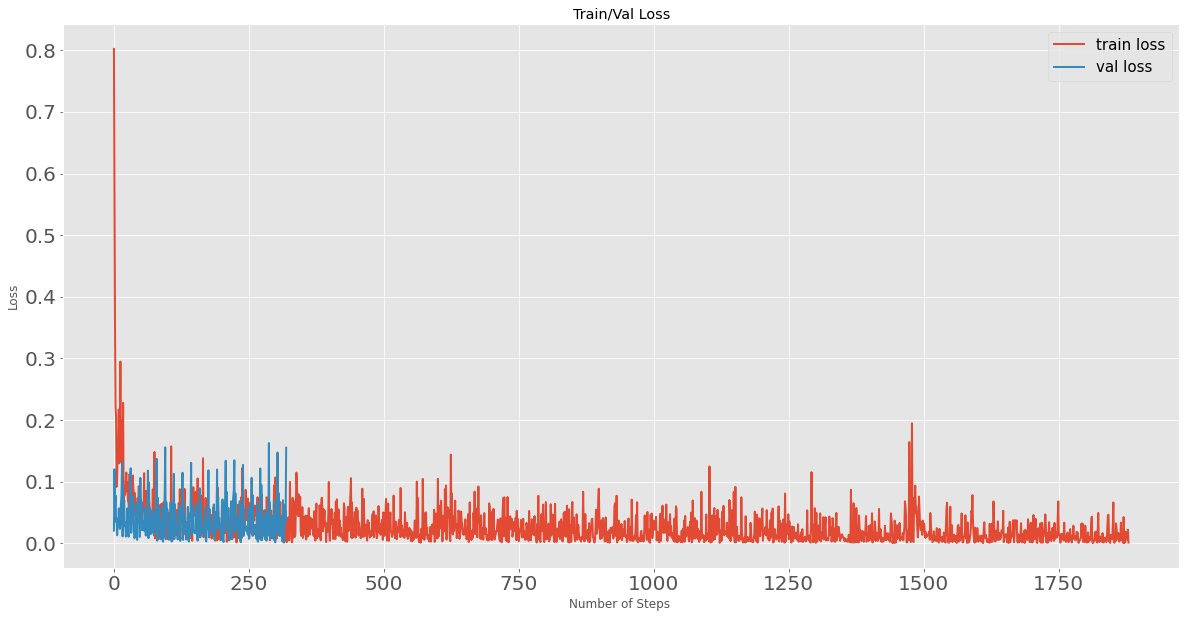

In [82]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the loss and acc
def plot_loss_fig(train_loss, val_loss):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
    plt.plot(range(len(val_loss)), val_loss, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Loss")  
    plt.ylabel('Loss') 
    plt.xlabel('Number of Steps ')
plot_loss_fig(train_all_loss, val_all_loss)

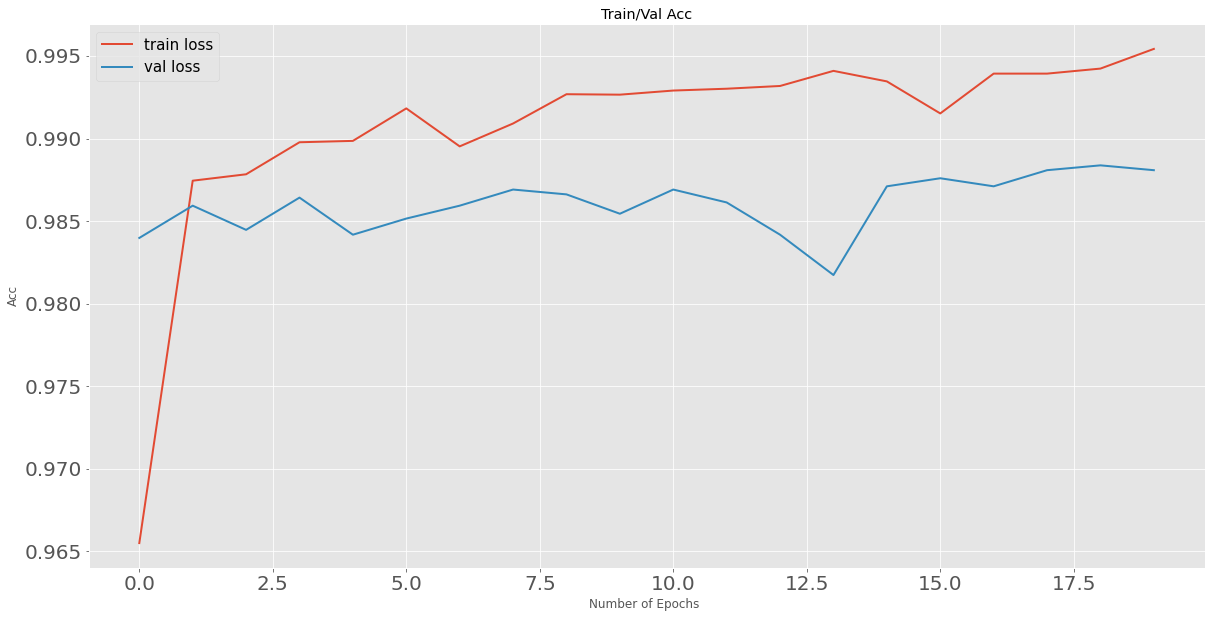

In [83]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the acc and acc
def plot_acc_fig(train_acc, val_acc):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_acc)), train_acc, label = 'train loss')
    plt.plot(range(len(val_acc)), val_acc, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Acc")  
    plt.ylabel('Acc') 
    plt.xlabel('Number of Epochs ')
plot_acc_fig(train_acc, val_acc)

In [84]:
torch.save(our_net.state_dict(), dir_path+'naturally_trained_model_cifar.pt')

# Adversarial Training Procedure


In [87]:
import copy 

LR = 0.01
NUM_EPOCH = 40
LOG_STEP = 200

adv_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(adv_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    adv_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader): 
        attacker = torchattacks.PGD(adv_net, eps=8/255, alpha=2/255, steps=32, random_start=True)
        train_labels = train_labels.long()
        # Generate adv. examples to mix in 
        atk_inds = np.random.choice(range(train_sample.shape[0])//2, size=train_sample.shape[0], replace=False)
        orig_inds = [ind for ind in range(train_sample.shape[0]) if ind not in atk_inds]
        #adv_samples = attacker(normalization(train_sample[atk_inds], mean=mean, std=std).float(), train_labels[atk_inds])
        adv_samples = attacker(train_sample[atk_inds], train_labels[atk_inds])
        orig_samples = train_sample[orig_inds]
        mixed_set = torch.cat((adv_samples, orig_samples))
        mixed_labels = torch.cat((train_labels[atk_inds], train_labels[orig_inds]))
        
        # output = adv_net(normalization(mixed_set, mean=mean, std=std).float())
        output = adv_net(mixed_set.float())
        loss = criterion(output, mixed_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    adv_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            # outputs = adv_net(normalization(val_sample, mean=mean, std=std).float())
            outputs = adv_net(val_sample).float()
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))

Epoch 0 Current Step 0/94: loss is 1.291564
------------------------------------------------
Epoch 0 Validation acc is 0.975391
Epoch 1 Current Step 0/94: loss is 0.146570
------------------------------------------------
Epoch 1 Validation acc is 0.980762
Epoch 2 Current Step 0/94: loss is 0.084298
------------------------------------------------
Epoch 2 Validation acc is 0.983496
Epoch 3 Current Step 0/94: loss is 0.082995
------------------------------------------------
Epoch 3 Validation acc is 0.984180
Epoch 4 Current Step 0/94: loss is 0.084757
------------------------------------------------
Epoch 4 Validation acc is 0.982227
Epoch 5 Current Step 0/94: loss is 0.063995
------------------------------------------------
Epoch 5 Validation acc is 0.983594
Epoch 6 Current Step 0/94: loss is 0.121554
------------------------------------------------
Epoch 6 Validation acc is 0.985449
Epoch 7 Current Step 0/94: loss is 0.057868
------------------------------------------------
Epoch 7 Val

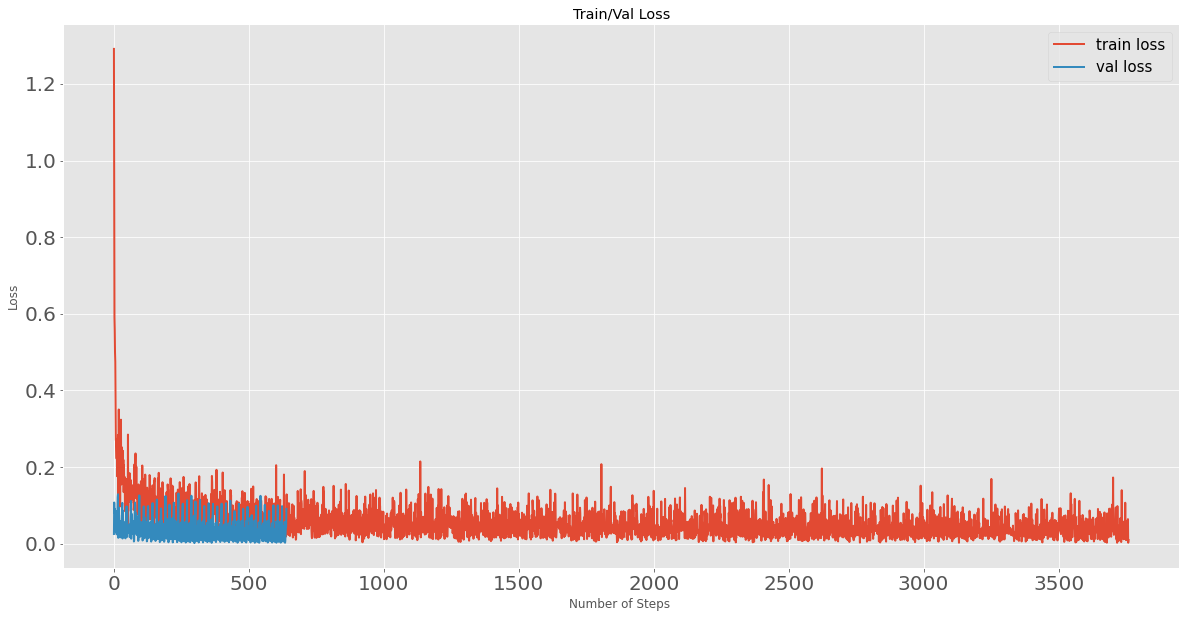

In [88]:
plot_loss_fig(train_all_loss, val_all_loss)

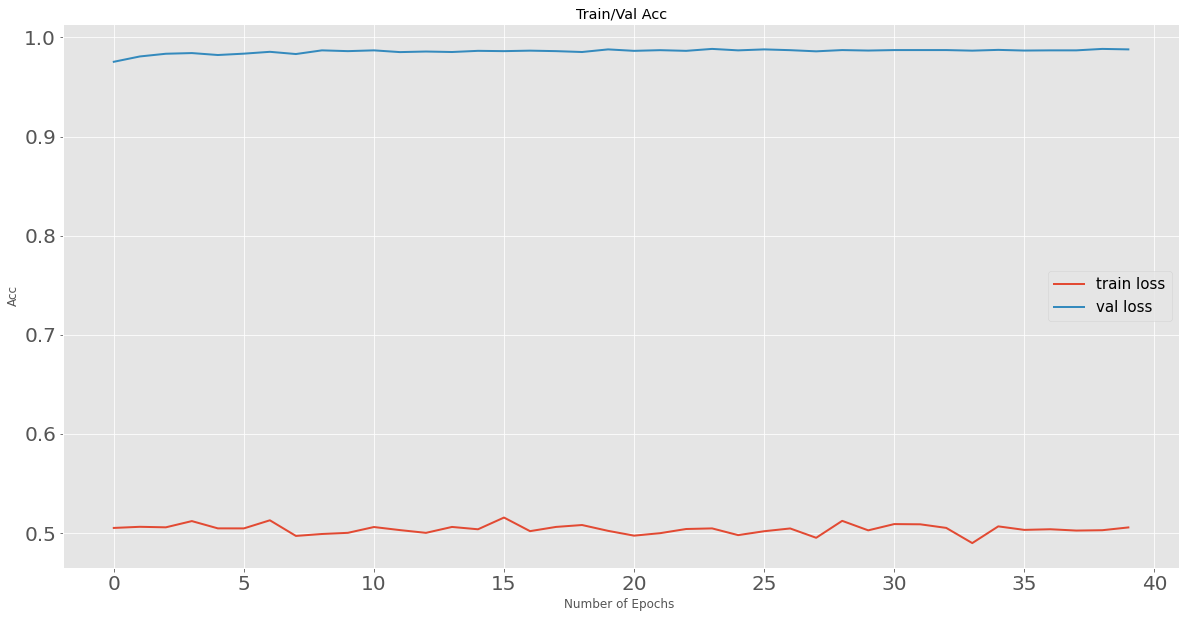

In [89]:
plot_acc_fig(train_acc, val_acc)

In [90]:
from torch import unsqueeze
num_wrong_nat = 0
num_attempt_nat = 0
num_wrong_adv = 0
num_attempt_adv = 0
for batch_id, (train_sample, train_labels) in enumerate(val_loader):
    for j in range(train_sample.shape[0]):
        instance = unsqueeze(train_sample[j], 0)
        label = unsqueeze(train_labels[j], 0)

        attacker_nat = torchattacks.PGD(our_net, eps=16/255, alpha=2/255, steps=32, random_start=True)
        adv_image = attacker_nat(instance.float(), label.long())
        model_guess_nat = our_net(instance.float()).max(1).indices
        adv_guess_nat = our_net(adv_image.float()).max(1).indices
        if model_guess_nat !=  adv_guess_nat:
            num_wrong_nat += 1
        num_attempt_nat += 1

        attacker_adv = torchattacks.PGD(adv_net, eps=16/255, alpha=2/255, steps=32, random_start=True)
        adv_image = attacker_adv(instance.float(), label.long())
        model_guess_adv = adv_net(instance.float()).max(1).indices
        adv_guess_adv = adv_net(adv_image.float()).max(1).indices
        if model_guess_adv !=  adv_guess_adv:
            num_wrong_adv += 1
        num_attempt_adv += 1

print('Number Incorrect (natural model): {}'.format(num_wrong_nat))
print('Number Attempted (natural model): {}'.format(num_attempt_nat))

print('Number Incorrect (adversarially trained model): {}'.format(num_wrong_adv))
print('Number Attempted (adversarially trained model): {}'.format(num_attempt_adv))

Number Incorrect (natural model): 878
Number Attempted (natural model): 2000
Number Incorrect (adversarially trained model): 77
Number Attempted (adversarially trained model): 2000


In [91]:
torch.save(adv_net.state_dict(), dir_path+'adversarially_trained_model_cifar.pt')

# Recourse Generation: Setup



In [10]:
nat_model_state = torch.load('naturally_trained_model_cifar.pt')
nat_model = my_net()
nat_model.load_state_dict(nat_model_state)

adv_model_state = torch.load('adversarially_trained_model_cifar.pt')
adv_model = my_net()
adv_model.load_state_dict(adv_model_state)


<All keys matched successfully>

In [11]:
feature_cols = []
for i in range(32):
    for j in range(32):
        feature_cols.append('pixel_{}_{}'.format(i, j))


In [12]:
features_train = torch.flatten(torch.Tensor(features_train).float(), start_dim=1).detach().numpy()

In [13]:
import pandas as pd
df = pd.DataFrame(features_train, columns=feature_cols)
df['Income_Greater_50k'] = label_train
df['Income_Greater_50k'] = df['Income_Greater_50k'].astype(int)
df.head()


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_0_8,pixel_0_9,...,pixel_31_23,pixel_31_24,pixel_31_25,pixel_31_26,pixel_31_27,pixel_31_28,pixel_31_29,pixel_31_30,pixel_31_31,Income_Greater_50k
0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.000000,0.000000,0.000000,...,0.498039,0.309804,0.054902,0.000000,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.003922,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003922,0.039216,0.458824,...,0.584314,0.105882,0.011765,0.007843,0.003922,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.392157,0.027451,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1


In [14]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features_train))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features_train)*0.8)]  # 80% data for training
val_index = random_index[int(len(features_train)*0.8):]


# generate the training data and validation data
train_data_df = df.iloc[train_index]
val_data_df = df.iloc[val_index]


In [15]:
from carla import Data

# Custom data set implementations need to inherit from the Data interface
class IncomeDataset(Data):

    def __init__(self, data, train, val, feature_cols):
        # The data set can e.g. be loaded in the constructor
        self._dataset = data
        self._train = train
        self._val = val
        self.feature_cols = feature_cols

    # List of all categorical features
    @property
    def categorical(self):
        return []

    # List of all continuous features
    @property
    def continuous(self):
        return self.feature_cols

    # List of all immutable features which
    # should not be changed by the recourse method
    @property
    def immutables(self):
        return []

    # Feature name of the target column
    @property
    def target(self):
        return 'Income_Greater_50k'
    
    @property
    def df(self):
        return self._dataset
        pass

    @property
    def df_train(self):
        return self._train

    @property
    def df_test(self):
        return self._val

    def transform(self, df):
        new_vals = normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)

    def inverse_transform(self, df):
        new_vals = inverse_normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)
    
    def normalization(tensor, mean, std):
        return ((tensor - mean) / std).float()
    
    def inverse_normalization(x, mean, std):
        return (x*std)+mean
    
ds = IncomeDataset(df, train_data_df, val_data_df, feature_cols)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/f

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [16]:
from carla import MLModel

# Custom black-box models need to inherit from
# the MLModel interface
class MyOwnModel(MLModel):
    def __init__(self, data, model, feature_cols):
        super().__init__(data)
        # The constructor can be used to load or build an
        # arbitrary black-box-model
        self._mymodel = model
        self.feature_cols = feature_cols

    # List of the feature order the ml model was trained on
    @property
    def feature_input_order(self):
        return self.feature_cols
    # The ML framework the model was trained on
    @property
    def backend(self):
        return "pytorch"

    # The black-box model object
    @property
    def raw_model(self):
        return self._mymodel

    # The predict function outputs
    # the continuous prediction of the model
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        return self._mymodel(x).max(1).indices

    # The predict_proba method outputs
    # the prediction as class probabilities
    def predict_proba(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        logits = self._mymodel(x)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().numpy()
    
nat_model_carla = MyOwnModel(ds, nat_model, feature_cols)
adv_model_carla = MyOwnModel(ds, adv_model, feature_cols)

## Recourse Generation-- Growing Spheres

In [16]:
#from carla import OnlineCatalog, MLModelCatalog
from carla.recourse_methods import GrowingSpheres

# # get factuals from the data to generate counterfactual examples
factuals = ds.df[:500]

# # load a recourse model and pass black box model
gs_1 = GrowingSpheres(nat_model_carla)

# # generate counterfactual examples
counterfactuals_1 = gs_1.get_counterfactuals(factuals)

# # load a recourse model and pass black box model
gs_2 = GrowingSpheres(adv_model_carla)

# # generate counterfactual examples
counterfactuals_2 = gs_2.get_counterfactuals(factuals)


KeyboardInterrupt: 

In [24]:
factuals

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,...,pixel_31_28,pixel_31_29,pixel_31_30,pixel_31_31,Income_Greater_50k
0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1
496,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0
497,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1
498,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1


In [25]:
sum(factuals['Income_Greater_50k']==1)

266

In [26]:
counterfactuals_1

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,...,pixel_31_28,pixel_31_29,pixel_31_30,pixel_31_31,Income_Greater_50k
0,-0.169695,-0.625751,-0.119098,-1.206381,0.847054,...,0.303629,0.139427,0.615634,0.004502,1.0
1,-0.061701,0.157371,-0.179982,-0.056893,0.043313,...,-0.034444,0.169634,0.020025,-0.003758,1.0
2,0.132308,-0.070631,-0.010021,-0.018808,-0.055772,...,0.006989,0.111280,-0.068335,-0.085170,1.0
3,-1.092819,-0.515709,-0.112144,1.071051,0.044882,...,-0.285361,0.563856,-0.123675,-0.746886,1.0
4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
496,0.466770,0.124670,-0.569519,0.841125,0.382656,...,-0.061969,-0.383005,-0.599805,-0.761943,1.0
497,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [47]:
counterfactuals_2

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,...,pixel_31_28,pixel_31_29,pixel_31_30,pixel_31_31,Income_Greater_50k
0,1.116168,0.568203,-0.594107,0.384450,-0.101069,...,1.517370,-0.308193,0.255253,0.294801,1.0
1,-0.062027,0.111667,-0.125122,0.178089,0.088399,...,-0.056358,0.130624,-0.289321,-0.236128,1.0
2,0.100965,-0.003192,-0.046114,-0.042365,0.060089,...,-0.046386,0.041966,0.038243,0.133604,1.0
3,-0.939348,-0.797049,0.318105,0.231940,-0.559515,...,0.029473,-0.773379,-0.205289,-0.084993,1.0
4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
496,-0.089768,-0.461623,0.394211,-1.479154,0.183900,...,-0.535693,0.736844,-0.791135,0.685059,1.0
497,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [28]:
factuals.shape[0]-sum(factuals['Income_Greater_50k']==1)

234

In [29]:
sum(counterfactuals_1['pixel_0_0'].notnull())

237

In [30]:
sum(counterfactuals_1['pixel_0_0'].notnull())/(factuals.shape[0]-sum(factuals['Income_Greater_50k']==1))

1.0128205128205128

In [31]:
sum(counterfactuals_2['pixel_0_0'].notnull())/(factuals.shape[0]-sum(factuals['Income_Greater_50k']==1))

1.0128205128205128

In [32]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import List

from carla.models.api import MLModel
from carla.recourse_methods.api import RecourseMethod
from carla.evaluation.distances import get_distances


def yNN_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    y: int = 10,
    dist_type: int =1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=y).fit(positive_class.values)

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
        knn = nbrs.kneighbors(row.values.reshape((1, -1)), y, return_distance=False)[0]
        distances_local = 0
        
        for idx in knn:
            neighbour = positive_class.iloc[idx]
            neighbour = neighbour.drop(mlmodel.data.target)
            neighbour = neighbour.values.reshape((1, -1))
            row_copy = row.drop(mlmodel.data.target)
            row_copy = row_copy.values.reshape((1, -1))
            
            distances_local += get_distances(row_copy, neighbour)[0][dist_type]
        distances.append((1 / y) * distances_local)
    return distances

def sphere_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    sphere_factor: float = 0.8,
    dist_type: int = 2,
)-> List[List[float]]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
        all_deltas = np.asarray(factuals.df.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        all_dists = np.sum(np.square(np.abs(all_deltas)), axis=1, dtype=np.float)
        all_euc_dist = np.sqrt(all_dists)
        radius = np.mean(all_euc_dist)*sphere_factor

        pos_deltas = np.asarray(positive_class.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        pos_dists = np.sum(np.square(np.abs(pos_deltas)), axis=1, dtype=np.float)
        pos_euc_dist = np.sqrt(pos_dists)
        relevant_neighbors = np.where(pos_euc_dist < radius)[0]
        #print(relevant_neighbors)
        if len(relevant_neighbors) == 0:
            distances.append(np.nan)
        else:
            relevant_distances = pos_euc_dist[relevant_neighbors]
            distances.append(np.mean(relevant_distances))
        
    return distances



In [33]:
ynn_1 = yNN_manifold(ds, counterfactuals_1, gs_1, nat_model_carla)
ynn_2 = yNN_manifold(ds, counterfactuals_2, gs_2, adv_model_carla)


In [34]:
sphere_1 = sphere_manifold(ds, counterfactuals_1, gs_1, nat_model_carla)
sphere_2 = sphere_manifold(ds, counterfactuals_2, gs_2, adv_model_carla)


In [35]:
ynn_1 = [val for val in ynn_1 if not pd.isnull(val)]
ynn_2 = [val for val in ynn_2 if not pd.isnull(val)]


In [36]:
print(np.mean(ynn_1))
print(np.mean(ynn_2))


322.9534111276031
369.7706679788419


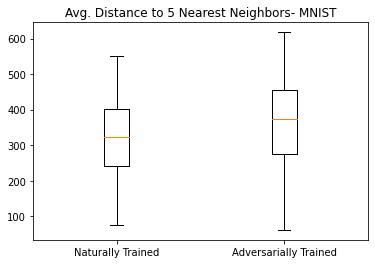

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([ynn_1, ynn_2])
plt.title('Avg. Distance to 5 Nearest Neighbors- MNIST')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()


In [38]:
sphere_1 = [val for val in sphere_1 if not pd.isnull(val)]
sphere_2 = [val for val in sphere_2 if not pd.isnull(val)]


In [39]:
print(np.mean(sphere_1))
print(np.mean(sphere_2))


9.144302852215045
9.70110026234104


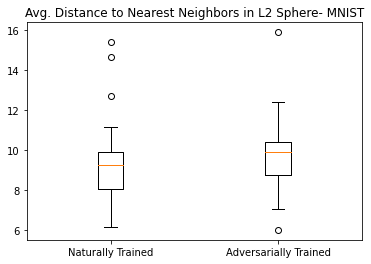

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([sphere_1, sphere_2])
plt.title('Avg. Distance to Nearest Neighbors in L2 Sphere- MNIST')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

In [41]:
def dist(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    y: int = 5,
    dist_type: int = 1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
            
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        
        row_copy = row.drop(mlmodel.data.target)
        row_copy = row_copy.values.reshape((1, -1))
        distances.append(get_distances(row_copy, original)[0][dist_type])
    return distances

dist_1 = dist(ds, counterfactuals_1, gs_1, nat_model_carla)
dist_2 = dist(ds, counterfactuals_2, gs_2, adv_model_carla)



In [42]:
dist_1 = [val for val in dist_1 if not pd.isnull(val)]
dist_2 = [val for val in dist_2 if not pd.isnull(val)]


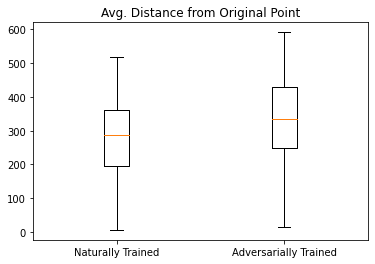

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([dist_1, dist_2])
plt.title('Avg. Distance from Original Point')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()


Text(0, 0.5, 'Proximity to Positive Manifold')

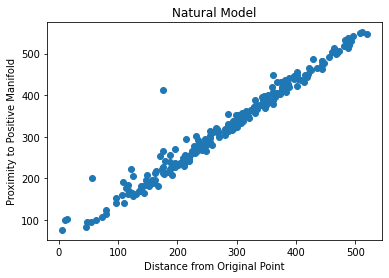

In [44]:
plt.scatter(dist_1, ynn_1)
plt.title('Natural Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')


Text(0, 0.5, 'Proximity to Positive Manifold')

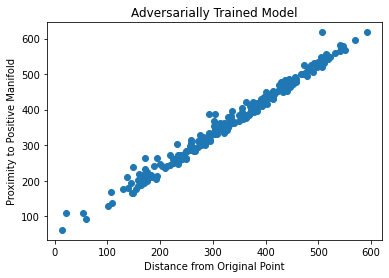

In [45]:
plt.scatter(dist_2, ynn_2)
plt.title('Adversarially Trained Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')


In [46]:
counterfactuals_1.to_csv('gs_cfs_natural_model_fashion.csv')
counterfactuals_2.to_csv('gs_cfs_adv_model_fashion.csv')

# Recourse Generation: Actionable Recourse


In [17]:
custom_bounds = {}
for col in ds.df[nat_model_carla.feature_input_order].columns:
    custom_bounds[col] = (0, 1, "percentile")

In [42]:

a = [-2.2,-0.2,0.8,-0.2]
a = [0.6,1.6,-1.4,1.6]
b= [-1.5,-0.5,1.5,0.5]
from numpy import dot
from numpy.linalg import norm

cos_sim = dot(a, b)/(norm(a)*norm(b))
cos_sim

-0.49186937683796467

In [19]:
%%time
#from carla import OnlineCatalog, MLModelCatalog
from carla.recourse_methods import ActionableRecourse

# # get factuals from the data to generate counterfactual examples
factuals = ds.df[:2]

DEFAULT_HYPERPARAMS = {
        "fs_size": 500,
        "discretize": True,
        "sample": True,
    }

# # load a recourse model and pass black box model
ar_1 = ActionableRecourse(nat_model_carla, DEFAULT_HYPERPARAMS, custom_bounds = custom_bounds)

# # generate counterfactual examples
counterfactuals_ar_1 = ar_1.get_counterfactuals(factuals)

# # load a recourse model and pass black box model
ar_2 = ActionableRecourse(adv_model_carla, DEFAULT_HYPERPARAMS)

# # generate counterfactual examples
counterfactuals_ar_2 = gs_2.get_counterfactuals(factuals)


[INFO] Start generating LIME coefficients [model.py get_counterfactuals]
[INFO] Finished generating LIME coefficients [model.py get_counterfactuals]


AssertionError: 

In [18]:
np.arange(0,0,0.1)

array([], dtype=float64)

In [81]:
list_ = []
for col in ds.df[nat_model_carla.feature_input_order].columns:
    list_.append(sum(np.isinf((ds.df[nat_model_carla.feature_input_order][col].values))))

In [17]:
mins = []
maxs = []
for col in ds.df[nat_model_carla.feature_input_order].columns:
    mins.append(min(ds.df[nat_model_carla.feature_input_order][col]))
    maxs.append(max(ds.df[nat_model_carla.feature_input_order][col]))
    

In [23]:
maxs

[0.027450980618596077,
 0.0784313753247261,
 0.3529411852359772,
 0.34117648005485535,
 0.4431372582912445,
 0.6980392336845398,
 0.729411780834198,
 0.8313725590705872,
 0.8549019694328308,
 0.9215686321258545,
 0.9686274528503418,
 0.9607843160629272,
 0.9921568632125854,
 0.9843137264251709,
 0.9960784316062927,
 1.0,
 1.0,
 1.0,
 0.9960784316062927,
 0.9764705896377563,
 0.9725490212440491,
 0.9725490212440491,
 0.9647058844566345,
 0.9411764740943909,
 0.9411764740943909,
 0.7647058963775635,
 0.5372549295425415,
 0.6352941393852234,
 0.43921568989753723,
 0.4156862795352936,
 0.09019608050584793,
 0.4745098054409027,
 0.05882352963089943,
 0.05882352963089943,
 0.5490196347236633,
 0.8156862854957581,
 0.843137264251709,
 0.9058823585510254,
 0.9215686321258545,
 0.9490196108818054,
 0.929411768913269,
 0.95686274766922,
 0.9647058844566345,
 0.9686274528503418,
 0.9764705896377563,
 0.9803921580314636,
 0.9843137264251709,
 0.9882352948188782,
 0.9882352948188782,
 0.98431372642

In [18]:
cols_to_adjust = []
for col in ds.df[nat_model_carla.feature_input_order].columns:
    if all(ds.df[nat_model_carla.feature_input_order][col]==0):
        cols_to_adjust.append(col)
cols_to_adjust


[]

In [82]:
sum(list_)

0

In [86]:
ds.df.dropna()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,...,pixel_31_28,pixel_31_29,pixel_31_30,pixel_31_31,Income_Greater_50k
0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0
1,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0
2,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0
3,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0
4,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.003922,0.003922,0.003922,...,0.003922,0.0,0.0,0.0,0
11996,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1
11997,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1
11998,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1


In [37]:
from numpy import dot
from numpy.linalg import norm

a = np.asarray([0,0,1.5,0,0.75,0])
b = np.asarray([3,3,0,0,1.5,0])
cos_sim = dot(a, b)/(norm(a)*norm(b))
cos_sim

0.14907119849998596

In [31]:
from scipy import spatial

result = 1 - spatial.distance.cosine(a, b)
result

0.7745966692414834

In [28]:
np.sqrt(1.5**2+0.75**2)*np.sqrt(1.5**2+1.5**2+1.5**2)

4.3571062644833445

In [33]:
(1.5*1.5+1.5*0.75)

3.375

In [34]:
3.375/4.3571062644833445

0.7745966692414833

In [30]:
4.875/4.3571062644833445

1.1188618555710315

In [23]:
a = np.asarray([0, 0, 1.5, 0, 0.75, 0])

SyntaxError: invalid character in identifier (614721979.py, line 1)

In [25]:
[0,0,1.5,0,0.75,0]

[0, 0, 1.5, 0, 0.75, 0]